In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install transformers timm pandas scikit-learn matplotlib seaborn tqdm --quiet

#Imports and Setup
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from transformers import ViTImageProcessor, ViTModel
from torchvision.datasets import ImageFolder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.2 MB/s eta 0:00:0000:0100:01


2025-06-10 05:59:27.998959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749535168.183126      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749535168.236923      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration
class Config:
    data_root = Path("/kaggle/input/data-flower/dataset")
    model_name = "google/vit-base-patch16-224"
    batch_size = 32
    img_size = 224
    grid_size = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print("Configuration loaded:")
print(f"Device: {Config.device}")
print(f"Image size: {Config.img_size}")
print(f"Grid size: {Config.grid_size}\n")

print(" Loading datasets...")
start = time.time()

train_dataset = ImageFolder(Config.data_root/'train')
valid_dataset = ImageFolder(Config.data_root/'valid')

print(f"Datasets loaded in {time.time()-start:.1f}s")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Class counts: {len(train_dataset.classes)}\n")

Configuration loaded:
Device: cuda
Image size: 224
Grid size: 2

 Loading datasets...
Datasets loaded in 20.3s
Train samples: 6552
Validation samples: 818
Class counts: 102



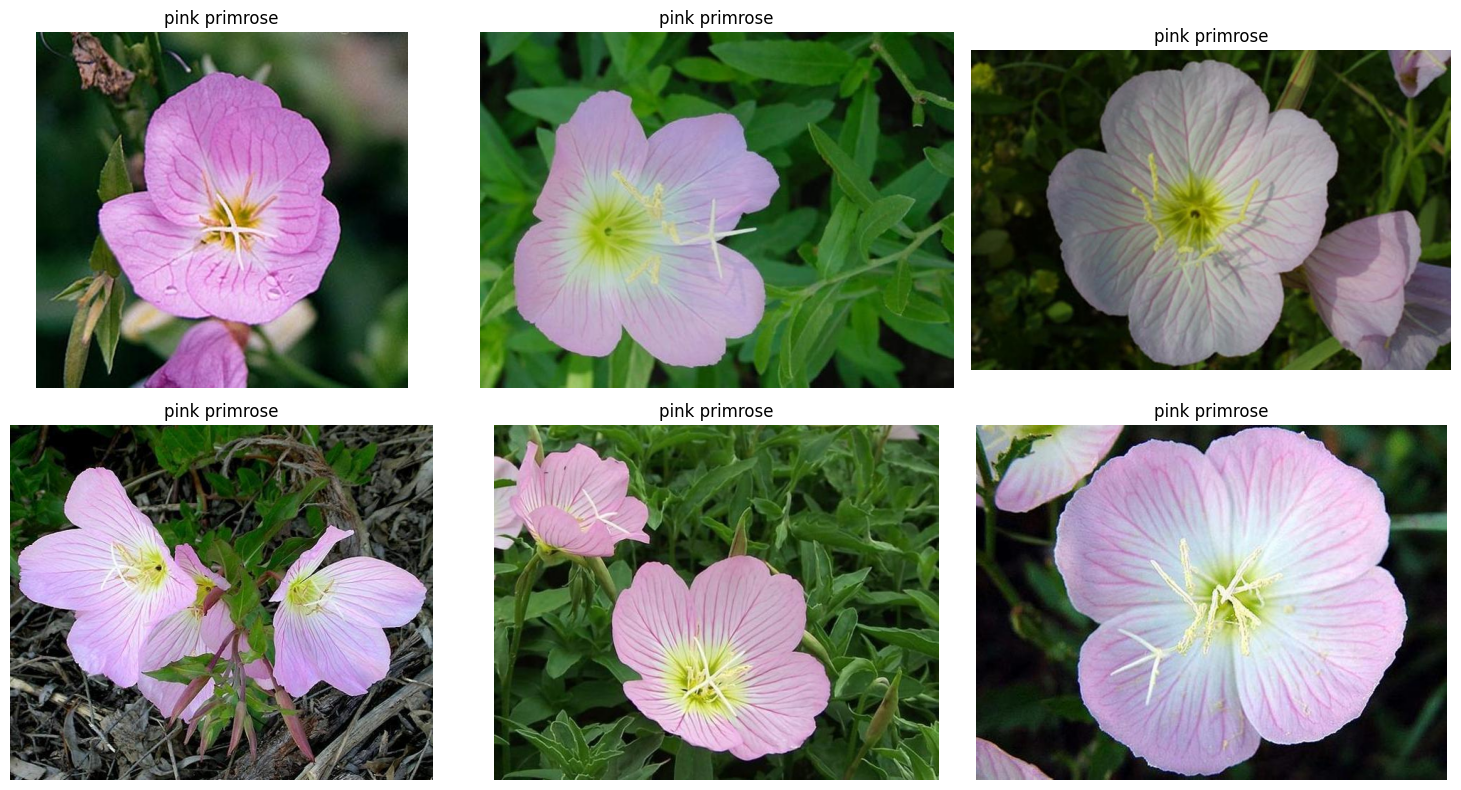

In [3]:
import json
import matplotlib.pyplot as plt
from PIL import Image

# Load label-to-name mapping and convert keys to zero-based integers
cat_to_name_path = Config.data_root.parent / 'cat_to_name.json'
with open(cat_to_name_path, 'r') as f:
    label_to_name = json.load(f)
label_to_name = {int(k) - 1: v for k, v in label_to_name.items()}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
shown_labels = list(set(train_dataset.targets))[:6]

shown = 0
for idx, (img_path, label) in enumerate(train_dataset.samples):
    if train_dataset.targets[idx] in shown_labels:
        image = Image.open(img_path).convert('RGB')
        ax = axes.flat[shown]
        ax.imshow(image)
        ax.set_title(f"{label_to_name[label]}")
        ax.axis('off')
        shown += 1
        if shown == 6:
            break

plt.tight_layout()
plt.show()


In [15]:
# Generate label-to-ID and ID-to-label mappings
labels_list = train_dataset.classes  # Already sorted and unique in ImageFolder

label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for label, i in label2id.items()}

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)


Mapping of IDs to Labels: {0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96',

In [9]:
import json

with open('/kaggle/input/data-flower/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print("example from cat_to_name:", list(cat_to_name.items())[:5])


class_to_idx = train_dataset.class_to_idx  
idx_to_class = {v: k for k, v in class_to_idx.items()}  

id2label = {idx: cat_to_name[idx_to_class[idx]] for idx in idx_to_class}
label2id = {v: k for k, v in id2label.items()}


print("\n Mapping from label index to flower name:")
for k in sorted(id2label):
    print(f"{k}: {id2label[k]}")


example from cat_to_name: [('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster')]

 Mapping from label index to flower name:
0: pink primrose
1: globe thistle
2: blanket flower
3: trumpet creeper
4: blackberry lily
5: snapdragon
6: colt's foot
7: king protea
8: spear thistle
9: yellow iris
10: globe-flower
11: purple coneflower
12: peruvian lily
13: balloon flower
14: hard-leaved pocket orchid
15: giant white arum lily
16: fire lily
17: pincushion flower
18: fritillary
19: red ginger
20: grape hyacinth
21: corn poppy
22: prince of wales feathers
23: stemless gentian
24: artichoke
25: canterbury bells
26: sweet william
27: carnation
28: garden phlox
29: love in the mist
30: mexican aster
31: alpine sea holly
32: ruby-lipped cattleya
33: cape flower
34: great masterwort
35: siam tulip
36: sweet pea
37: lenten rose
38: barbeton daisy
39: daffodil
40: sword lily
41: poinsettia
42: bolero deep blue
43: wallflower
44: mari

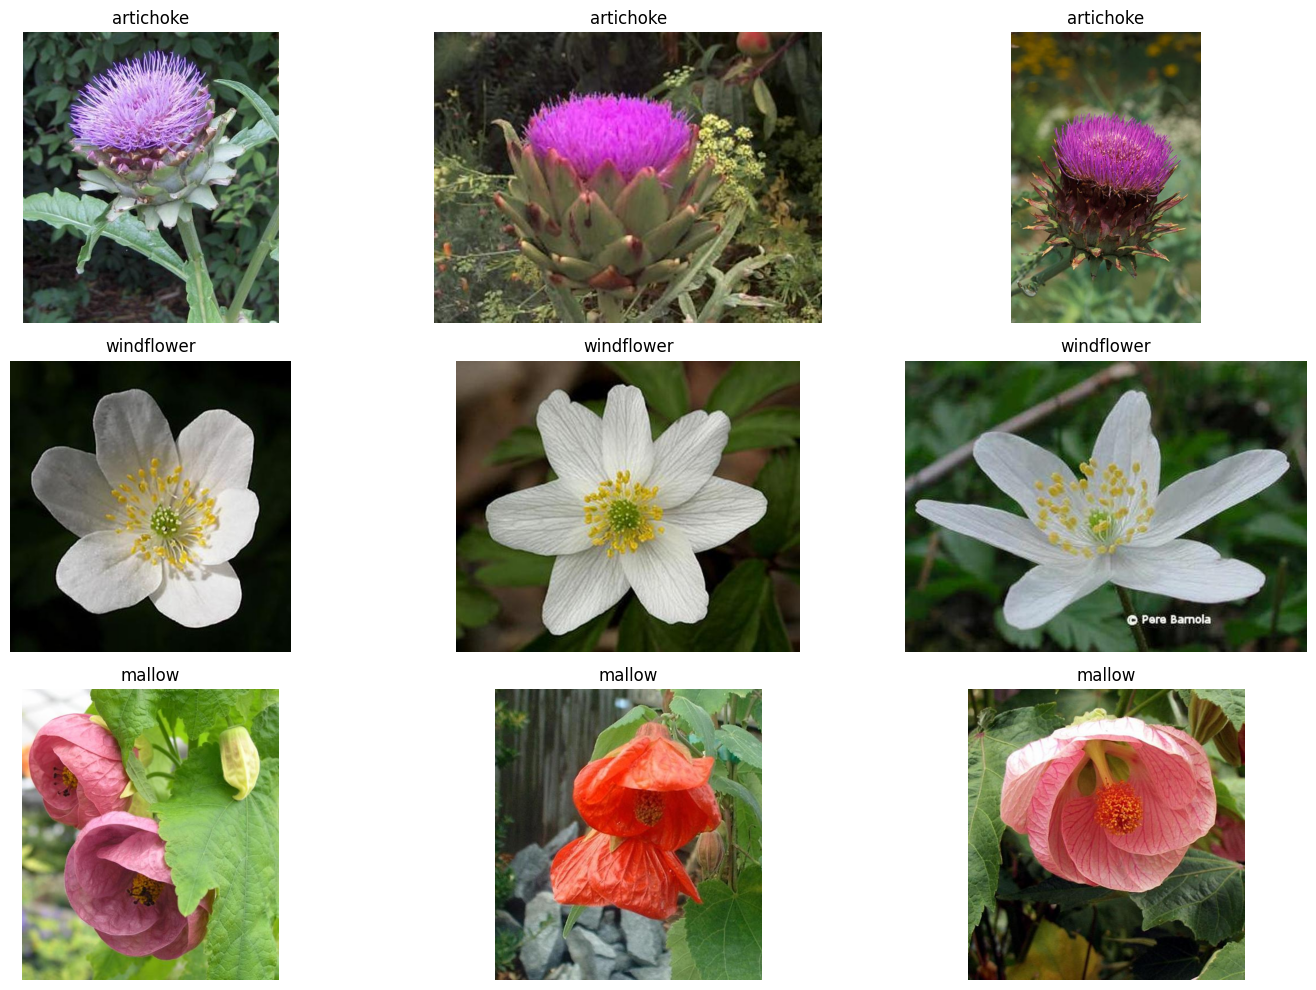

In [22]:
# Randomly 3
selected_labels = random.sample(list(set(train_dataset.targets)), 3)
label_count = {label: 0 for label in selected_labels}

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
shown = 0

for img_path, label in train_dataset.samples:
    if label in selected_labels and label_count[label] < 3:
        image = Image.open(img_path).convert('RGB')
        ax = axes.flat[shown]
        ax.imshow(image)
        ax.set_title(f"{id2label[label]}")
        ax.axis('off')
        label_count[label] += 1
        shown += 1
        if shown == 9:
            break

plt.tight_layout()
plt.show()


In [23]:
# Mount Google Drive
# print("Mounting Google Drive...")
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted!\n")

#ViT 
start = time.time()

processor = ViTImageProcessor.from_pretrained(Config.model_name)
model = ViTModel.from_pretrained(Config.model_name).to(Config.device)
model.eval()

print(f" ViT initialized in {time.time()-start:.1f}s")
print(f"Model: {Config.model_name}")
print(f"Processor: {processor}\n")

# Feature Extraction Utilities
def log_progress(current, total, prefix=""):
    print(f"\r{prefix} {current}/{total} ({current/total:.1%})", end="")

def extract_global_features(image):
    inputs = processor(image, return_tensors="pt").to(Config.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:,0].cpu().numpy()

def extract_grid_features(image):
    # inputs = processor(image, return_tensors="pt").to(Config.device)
    # with torch.no_grad():
    #     outputs = model(**inputs, output_hidden_states=True)
    # patch_embeddings = outputs.hidden_states[-1][:, 1:]
    # grid_features = patch_embeddings.reshape(-1, 14, 14, 768)
    
    # regional_features = []
    # for i in range(0, 14, 4):
    #     for j in range(0, 14, 4):
    #         region = grid_features[:, i:i+4, j:j+4, :]  # Slice 4x4 region
    #         regional_features.append(region.mean(dim=(1,2)))
    # return torch.cat(regional_features, dim=1).cpu().numpy()
    w, h = image.size
    grid_size = Config.grid_size
    tile_w, tile_h = w // grid_size, h // grid_size
    
    features = []
    for i in range(grid_size):
        for j in range(grid_size):
            left = j * tile_w
            upper = i * tile_h
            right = (j + 1) * tile_w
            lower = (i + 1) * tile_h
            tile = image.crop((left, upper, right, lower))

            inputs = processor(tile, return_tensors="pt").to(Config.device)
            with torch.no_grad():
                outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0].cpu().numpy()
            features.append(cls_embedding)

    return np.concatenate(features, axis=1)  # Shape: [1, 768 * (grid_size^2)]

# Feature Extraction 
def process_dataset(dataset, feature_fn, name="Dataset"):
    features, labels = [], []
    total = len(dataset)
    print(f"\n Processing {name} ({total} images)...")
    
    start = time.time()
    for idx, (img_path, label) in enumerate(tqdm(dataset.samples)):
        image = Image.open(img_path).convert('RGB')
        features.append(feature_fn(image))
        labels.append(label)
        
    print(f" {name} processed in {time.time()-start:.1f}s")
    return np.vstack(features), np.array(labels)

# all datasets
print(" Starting feature extraction...")
X_train_global, y_train = process_dataset(train_dataset, extract_global_features, "Train Global")
X_valid_global, y_valid = process_dataset(valid_dataset, extract_global_features, "Valid Global")

X_train_grid, _ = process_dataset(train_dataset, extract_grid_features, "Train Grid")
X_valid_grid, _ = process_dataset(valid_dataset, extract_grid_features, "Valid Grid")

print("\n Feature shapes:")
print(f"Global features: {X_train_global.shape[1]} dim")
print(f"Grid features: {X_train_grid.shape[1]} dim\n")

# Classifier Training
def train_evaluate(X_train, X_valid, model_type='logistic'):
    model_name = "Logistic Regression" if model_type == 'logistic' else "Decision Tree"
    print(f"\n Training {model_name}...")
    
    start = time.time()
    if model_type == 'logistic':
        clf = LogisticRegression(max_iter=1000, verbose=1)
    else:
        clf = DecisionTreeClassifier()
    
    clf.fit(X_train, y_train)
    train_time = time.time() - start
    
    print(f" Training time: {train_time:.1f}s")
    valid_preds = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, valid_preds)
    
    print(f" {model_name} trained")
    print(f"Validation accuracy: {accuracy:.3f}\n")
    return accuracy, clf

print("training...")
results = {}

# Global 
print("\n Global Features Models")
results['global_lr'], lr_global = train_evaluate(X_train_global, X_valid_global)
results['global_tree'], tree_global = train_evaluate(X_train_global, X_valid_global, 'tree')

# Grid 
print("\n Grid Features Models")
results['grid_lr'], lr_grid = train_evaluate(X_train_grid, X_valid_grid)
results['grid_tree'], tree_grid = train_evaluate(X_train_grid, X_valid_grid, 'tree')


def process_test_set():
    test_dir = Config.data_root/'test'
    test_files = list(test_dir.glob('*.jpg'))
    print(f"\n🔮 Processing {len(test_files)} test images...")
    
    features_global, features_grid = [], []
    for img_path in tqdm(test_files):
        image = Image.open(img_path).convert('RGB')
        features_global.append(extract_global_features(image))
        features_grid.append(extract_grid_features(image))
    
    return np.vstack(features_global), np.vstack(features_grid), test_files

print("\n Generating test predictions...")
X_test_global, X_test_grid, test_files = process_test_set()

# from best model 
test_preds = lr_global.predict(X_test_global)

submission = pd.DataFrame({
    'file': [f.name for f in test_files],
    'class': test_preds
})
submission.to_csv('flower_predictions.csv', index=False)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 ViT initialized in 3.2s
Model: google/vit-base-patch16-224
Processor: ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}


 Starting feature extraction...

 Processing Train Global (6552 images)...


100%|██████████| 6552/6552 [02:55<00:00, 37.32it/s]


 Train Global processed in 175.6s

 Processing Valid Global (818 images)...


100%|██████████| 818/818 [00:22<00:00, 36.06it/s]


 Valid Global processed in 22.7s

 Processing Train Grid (6552 images)...


100%|██████████| 6552/6552 [06:44<00:00, 16.22it/s]


 Train Grid processed in 404.0s

 Processing Valid Grid (818 images)...


100%|██████████| 818/818 [00:51<00:00, 15.93it/s]


 Valid Grid processed in 51.4s

 Feature shapes:
Global features: 768 dim
Grid features: 3072 dim

training...

 Global Features Models

 Training Logistic Regression...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.0s finished


 Training time: 53.0s
 Logistic Regression trained
Validation accuracy: 0.994


 Training Decision Tree...
 Training time: 46.9s
 Decision Tree trained
Validation accuracy: 0.725


 Grid Features Models

 Training Logistic Regression...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


 Training time: 65.8s
 Logistic Regression trained
Validation accuracy: 0.995


 Training Decision Tree...
 Training time: 213.0s
 Decision Tree trained
Validation accuracy: 0.620


 Generating test predictions...

🔮 Processing 819 test images...


100%|██████████| 819/819 [01:13<00:00, 11.18it/s]


In [26]:
# SVM, Linear Regression, Random Forest
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_evaluate_extended(X_train, X_valid, model_type):
    start = time.time()

    if model_type == 'svm':
        model_name = "Support Vector Machine"
        clf = SVC()
    elif model_type == 'ridge':
        model_name = "Ridge Classifier (Linear Regression)"
        clf = RidgeClassifier()
    elif model_type == 'rf':
        model_name = "Random Forest"
        clf = RandomForestClassifier(n_estimators=100)
    else:
        raise ValueError("Unknown model type")

    print(f"\n Training {model_name}...")
    clf.fit(X_train, y_train)
    train_time = time.time() - start

    valid_preds = clf.predict(X_valid)
    acc = accuracy_score(y_valid, valid_preds)
    print(f" {model_name} Validation Accuracy: {acc:.3f}")
    return acc, clf

print("\n Global Features Models")
# Global Feature Models
results['global_svm'], svm_global = train_evaluate_extended(X_train_global, X_valid_global, 'svm')
results['global_ridge'], ridge_global = train_evaluate_extended(X_train_global, X_valid_global, 'ridge')
results['global_rf'], rf_global = train_evaluate_extended(X_train_global, X_valid_global, 'rf')

# Grid Feature Models
print("\n Grid Features Models")
results['grid_svm'], svm_grid = train_evaluate_extended(X_train_grid, X_valid_grid, 'svm')
results['grid_ridge'], ridge_grid = train_evaluate_extended(X_train_grid, X_valid_grid, 'ridge')
results['grid_rf'], rf_grid = train_evaluate_extended(X_train_grid, X_valid_grid, 'rf')



 Global Features Models

 Training Support Vector Machine...
 Support Vector Machine Validation Accuracy: 0.989

 Training Ridge Classifier (Linear Regression)...
 Ridge Classifier (Linear Regression) Validation Accuracy: 0.995

 Training Random Forest...
 Random Forest Validation Accuracy: 0.978

 Grid Features Models

 Training Support Vector Machine...
 Support Vector Machine Validation Accuracy: 0.994

 Training Ridge Classifier (Linear Regression)...
 Ridge Classifier (Linear Regression) Validation Accuracy: 0.995

 Training Random Forest...
 Random Forest Validation Accuracy: 0.972
